In [5]:
import numpy as np

def n_body(t,x,p):
    """
    ODE function for the n-body problem.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - fix_first (bool): whether to fix the first particle in place

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # Extract parameters
    masses = np.array(p['m'])
    G = p['G']
    dimensions = p['dimension']
    n_bodies = len(masses)

    # Initialize derivative vector
    dxdt = np.zeros_like(x)

    # First half of dxdt is just the velocities from second half of x
    dxdt[:n_bodies*dimensions] = x[n_bodies*dimensions:]  # n_bodies = 3, dimensions = 2; dxdt[0:6] = x[6:12]

    # Initialize force matrices for each dimension
    force_matrices = np.zeros((dimensions, n_bodies, n_bodies))

    # Calculate forces between all pairs of bodies
    for i in range(n_bodies):
        for j in range(i+1, n_bodies):  # Only upper triangle

            # Calculate displacement vector between bodies i and j
            r_ij = []  # x, y
            for d in range(dimensions):
                displacement = x[i*dimensions + d] - x[j*dimensions + d]
                # print(f"Displacement between body {i} and body {j} in dimension {d}: {displacement}")
                r_ij.append(displacement)

            r_ij = np.array(r_ij)  # x, y displacement

            # Calculate distance
            r = np.sqrt(np.sum(r_ij**2))
            # print(f"Distance between body {i} and body {j}: {r}")

            # Calculate gravitational force magnitude
            force_mag = -G * masses[i] * masses[j] / (r**3)
            # print(f"Force magnitude between body {i} and body {j}: {force_mag}")

            # Calculate force components and fill force matrices
            for d in range(dimensions):
                force_matrices[d][i,j] = force_mag * r_ij[d]
                force_matrices[d][j,i] = -force_matrices[d][i,j]  # Fill in lower triangle

    # print("Force matrix x:")
    # print(force_matrices[0])
    # print("Force matrix y:")
    # print(force_matrices[1])

    # Sum forces on each body and calculate accelerations
    for i in range(n_bodies):
        if p.get('fix_first', False) and i == 0:
            # If fix_first is True, first body doesn't move
            continue

        # Calculate acceleration components for each dimension
        for d in range(dimensions):
            # print(force_matrices[d][i])
            total_force = np.sum(force_matrices[d][i])
            dxdt[n_bodies*dimensions + i*dimensions + d] = total_force / masses[i]  # vx1, vy1, vx2, vy2, vx3, vy3, [ax1, ay1,] ax2, ay2, ax3, ay3

    return dxdt

In [ ]:
def n_body_solar_wind(t, x, p):
    """
    ODE function for the n-body problem with a solar wind.

    Parameters:
    t (float): time (unused but required for ODE solver compatibility)
    x (np.array): state vector containing positions and velocities
    p (dict): parameters dictionary containing:
        - m (list): masses of particles
        - G (float): gravitational constant
        - dimension (int): number of spatial dimensions
        - fix_first (bool): whether to fix the first particle in place
        - W (float): magnitude of solar wind force in horizontal direction

    Returns:
    np.array: derivative of state vector (velocities and accelerations)
    """
    # First compute the gravitational forces using the original function
    dxdt = n_body(t, x, p)

    # Now add the solar wind effect
    W = p.get('W', 0)  # Solar wind magnitude

    if W != 0:
        # Solar wind acts on the satellite (assumed to be body index 1)
        satellite_index = 1
        dimensions = p['dimension']
        n_bodies = len(p['m'])

        # Add solar wind acceleration in x-direction to the satellite only
        # The +x direction is where the solar wind is coming from
        dxdt[n_bodies*dimensions + satellite_index*dimensions] += W

    return dxdt

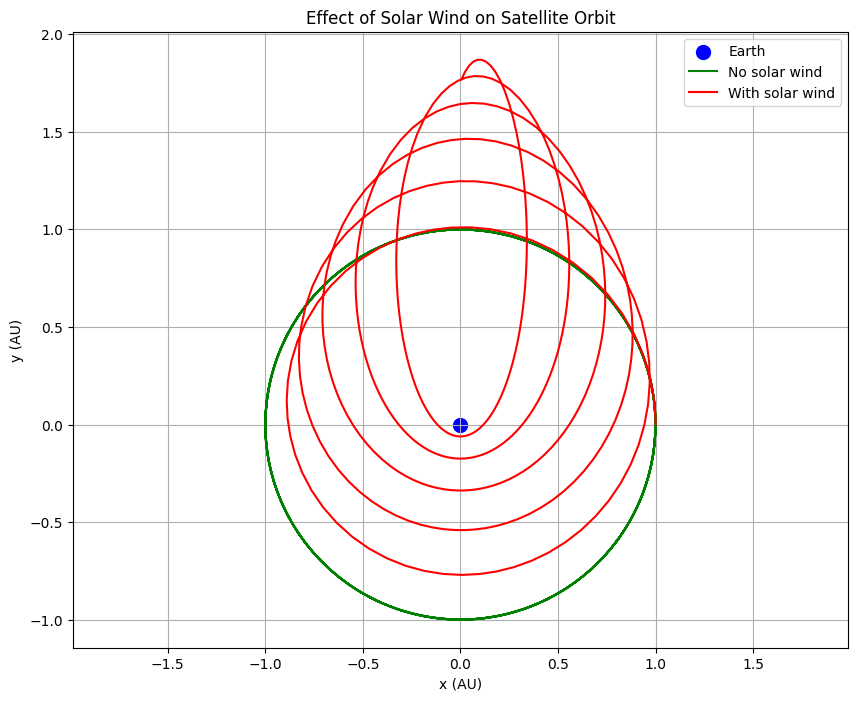

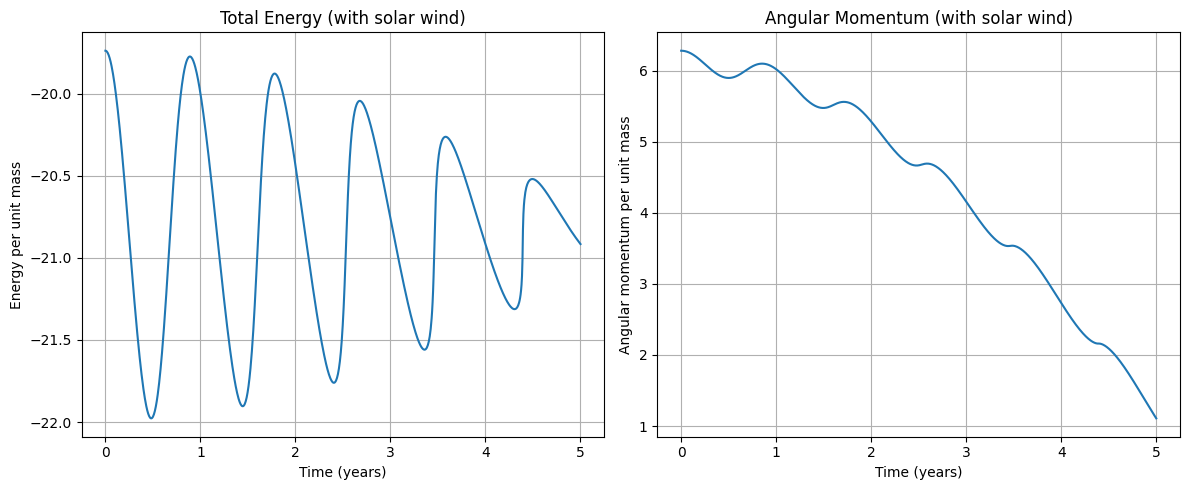

In [9]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

def simulate_satellite_with_solar_wind():
    # Parameters
    G = 4 * np.pi**2  # Gravitational constant in astronomical units

    # Earth mass (in proper units)
    earth_mass = 1.0

    # Satellite mass (negligible compared to Earth)
    satellite_mass = 1e-10

    # Parameters dictionary
    p = {
        'm': [earth_mass, satellite_mass],  # Earth and satellite
        'G': G,
        'dimension': 2,
        'fix_first': True,  # Earth fixed at origin
    }

    # Initial conditions for circular orbit
    r0 = 1.0  # 1 AU initial distance
    v_circular = np.sqrt(G * earth_mass / r0)  # Velocity for circular orbit

    # Initial state vector [x_earth, y_earth, x_sat, y_sat, vx_earth, vy_earth, vx_sat, vy_sat]
    x0 = np.array([0.0, 0.0, r0, 0.0, 0.0, 0.0, 0.0, v_circular])

    # Time span (in years)
    t_span = (0, 5)

    # Integrate without solar wind
    sol_no_wind = solve_ivp(
        n_body_solar_wind,
        t_span,
        x0,
        args=(p,),
        method='RK45',
        rtol=1e-8,
        atol=1e-8,
        dense_output=True
    )

    # Add solar wind (3% of gravitational acceleration)
    a_grav = G * earth_mass / (r0**2)
    W = 0.03 * a_grav
    p_wind = p.copy()
    p_wind['W'] = W

    # Integrate with solar wind
    sol_wind = solve_ivp(
        n_body_solar_wind,
        t_span,
        x0,
        args=(p_wind,),
        method='RK45',
        rtol=1e-8,
        atol=1e-8,
        dense_output=True
    )

    # Plot both orbits
    plt.figure(figsize=(10, 8))

    # Plot Earth
    plt.scatter(0, 0, color='blue', s=100, label='Earth')

    # Plot orbit without wind
    plt.plot(sol_no_wind.y[2], sol_no_wind.y[3], 'g-', label='No solar wind')

    # Plot orbit with wind
    plt.plot(sol_wind.y[2], sol_wind.y[3], 'r-', label='With solar wind')

    plt.title('Effect of Solar Wind on Satellite Orbit')
    plt.xlabel('x (AU)')
    plt.ylabel('y (AU)')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)

    # Also plot energy and angular momentum for the satellite with wind
    t_dense = np.linspace(t_span[0], t_span[1], 1000)

    # Get dense solution for wind case
    states_wind = sol_wind.sol(t_dense)

    # Extract satellite positions and velocities
    x_sat = states_wind[2]
    y_sat = states_wind[3]
    vx_sat = states_wind[6]
    vy_sat = states_wind[7]

    # Calculate distances from Earth
    r = np.sqrt(x_sat**2 + y_sat**2)

    # Calculate energy (per unit mass)
    KE = 0.5 * (vx_sat**2 + vy_sat**2)
    PE = -G * earth_mass / r
    E = KE + PE

    # Calculate angular momentum (per unit mass)
    L = x_sat * vy_sat - y_sat * vx_sat

    # Plot energy and angular momentum
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(t_dense, E)
    plt.title('Total Energy (with solar wind)')
    plt.xlabel('Time (years)')
    plt.ylabel('Energy per unit mass')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t_dense, L)
    plt.title('Angular Momentum (with solar wind)')
    plt.xlabel('Time (years)')
    plt.ylabel('Angular momentum per unit mass')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return sol_no_wind, sol_wind

# Run the simulation
sol_no_wind, sol_wind = simulate_satellite_with_solar_wind()